In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [46]:
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline
%config IPCompleter.use_jedi = False

## 2.1 Data exploration of Point Of Interest

1. Load the New York Point Of Interest dataset exploiting PaID metadata as well and filter out from the New York Poibelong to the New York municipality.  
• Which columns have been parsed?  
• Which is the type of the data inferred by Pandas?

In [3]:
poi_file = 'pois_all_info.tsv'
df_poi = pd.read_csv(poi_file, sep = '\t', low_memory=False)
df_poi.head()

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
4,42811266,node,40.704807,-73.772734,NaN,NaN,NaN,stop_position,NaN


In [4]:
df_poi.columns

Index(['@id', '@type', '@lat', '@lon', 'amenity', 'name', 'shop',
       'public_transport', 'highway'],
      dtype='object')

  • @id: a unique id for each point of interest.  
  • @lat: latitude coordinate of the POI in decimal degrees.  
  • @lon: longitude coordinate of the POI in decimal degrees.  
  • amenity name: if the POI category is amenity its type is reported in this fiel  
  • shop: if the POI category is shop its type is reported in this field.  
  • public_transport: if the POI category is public transport its type is reporte  
  • highway: if the POI category is highway its type is reported in this field

In [5]:
df_poi.dtypes

@id                   int64
@type                object
@lat                float64
@lon                float64
amenity              object
name                 object
shop                 object
public_transport     object
highway              object
dtype: object

2. For each column in the loaded dataset count the number of missing values.
• What did you expect?  
• What can you infer from this first analysis?

In [6]:
df_poi.isna().sum()

@id                     0
@type                   0
@lat                 2095
@lon                 2095
amenity             45613
name                37094
shop                65034
public_transport    67494
highway             68439
dtype: int64

In [7]:
df_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @id               77884 non-null  int64  
 1   @type             77884 non-null  object 
 2   @lat              75789 non-null  float64
 3   @lon              75789 non-null  float64
 4   amenity           32271 non-null  object 
 5   name              40790 non-null  object 
 6   shop              12850 non-null  object 
 7   public_transport  10390 non-null  object 
 8   highway           9445 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.3+ MB


We have a very sparse dataset.

3. Now, analyze the distribution of the POI types for each POI category. Point of interest categories areamenity, shop, public_transport and highway. For each of them, plot a histogram showing the distribution of the types of POI. Note that, for certain categories, due to the high number of types, bars and labels could not fit adequately in the figure. Hence, fix a threshold (a percentage one isbetter) and plot only the most frequent types.To simplify the subsequent analysis, use the retained top frequent POI types also for the followingexercises.

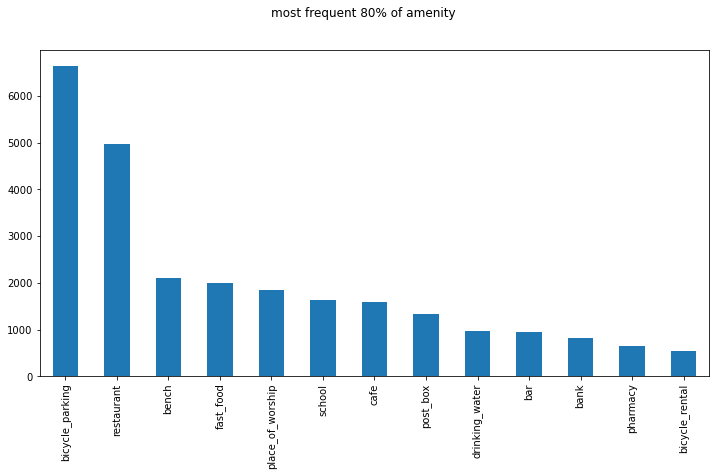

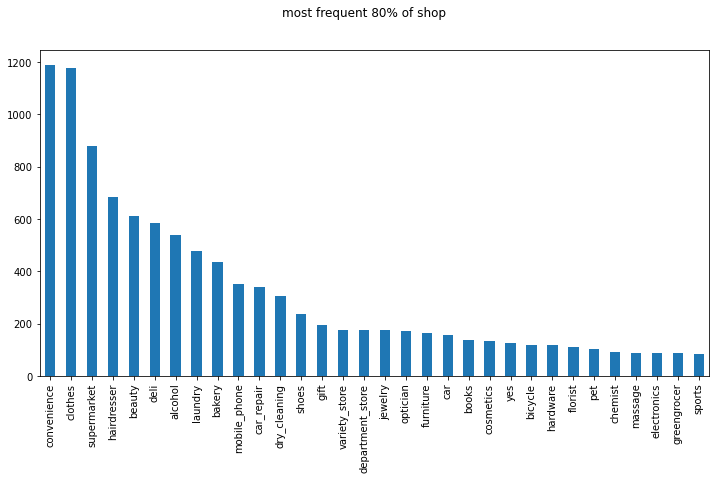

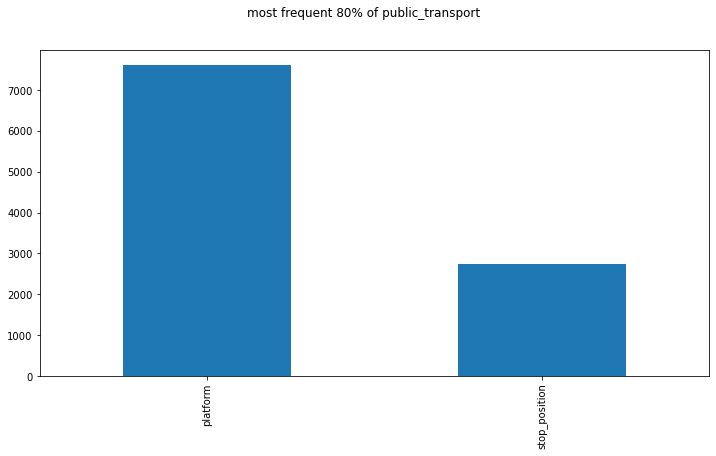

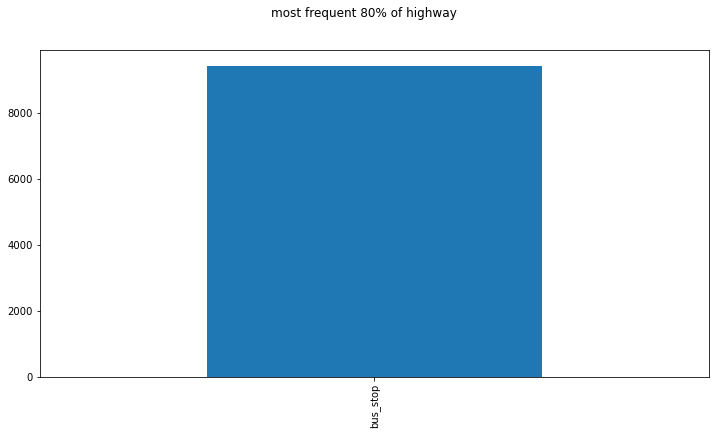

In [8]:
cats = ['amenity', 'shop', 'public_transport', 'highway']
pc = .8
for cat in cats:
    v_count = df_poi.loc[:,cat].value_counts()
    ind = ((v_count / v_count.sum()).cumsum() > pc ).argmax()
    fig, ax = plt.subplots()
    v_count.iloc[:ind+1].plot.bar(ax = ax)
    fig.suptitle(f"most frequent {pc*100:.0f}% of {cat}")
    plt.xticks(rotation = 90);

4. Show the points of interest on the New York map for a given category (e.g. amenity).  
To do so, you have to define a new function (or a new class) that,  
given the name of the POI category is able to show a scatter plot of the locations of the POI types, onto the New York municipality map, with a different color for each category.  
• Are you able to identify areas in which the concentration of a specific POI type is higher then others?  
• How can you better characterize the POI distributions?

__Map Class__

In [9]:
import seaborn as sns

class Map:
    def __init__(self, df):
        """ Store Dataset with POIs information."""
        self.pois_df = df
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
        self.long_min = df['@lon'].min()
        self.long_max = df['@lon'].max()
        
    def plot_map(self):
        """ Display an image with NY map and return the Axes object."""
        fig, ax = plt.subplots()
        nyc_img = plt.imread('New_York_City_Map.PNG')
        ax.imshow(nyc_img, zorder=0, extent=[self.long_min,
                                             self.long_max,
                                             self.lat_min,
                                             self.lat_max])
        ax.grid(False)
        return ax
        
    def plot_pois(self, ax, category, mask):
        """Plot data on specified Axis."""
        df = self.pois_df.loc[mask]
        
        # Version 1: using pandas
        types = df[category].unique()
        cmap = get_cmap('viridis')
        colors = cmap(np.linspace(0, 1, types.size))
        for i, t in enumerate(types):
            df_t = df.loc[df[category] == t]
            c = [colors[i]] *  df_t.shape[0]
            df_t.plot.scatter(x='@lon', y='@lat', ax=ax, c=c, alpha=.6, label=t)
        
        # Version 2: using seaborn
        # sns.scatterplot(df['@lon'], df['@lat'], hue=df[category], ax=ax, 
        #                 marker='o', s=3, linewidth=0, palette="viridis", legend='full')

        ax.legend() # show the legend, required by Version 1
        ax.grid(False)
        return ax

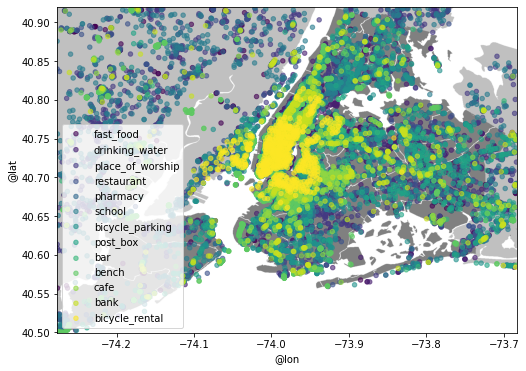

In [10]:
from matplotlib.cm import get_cmap
def get_top_perc(series, perc_value=.8):
    perc = series.cumsum() / series.sum()
    arg = (perc > perc_value).values.argmax()
    return series.iloc[:arg+1]


def show_category_on_map(df, column, perc_value):
    """
    Plot the New York map with POIs of a specific category.
    Only the top 'perc_value'% frequent types are plotted.
    """
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    ny_map = Map(df)
    
    ax = ny_map.plot_map()
    mask = df[column].isin(top_freq.index)
    ny_map.plot_pois(ax, column, mask)

show_category_on_map(df_poi, 'amenity', .8)

There is an evident concentration of pharmacies in the Manhattan neighborhood. However, we should consider that latest calls may superimpose points on top of the ones drawn by first calls. Let's look at the same chart, lowering the frequency threshold.


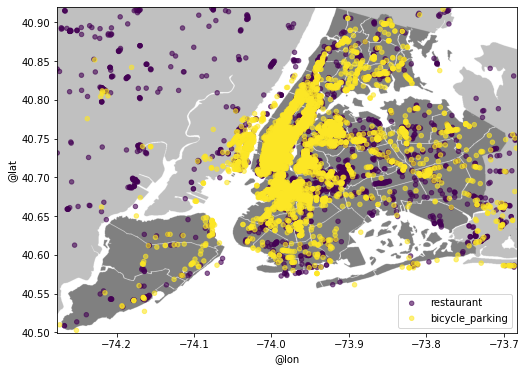

In [11]:
show_category_on_map(df_poi, 'amenity', .3)

__2.2 Data exploration and queries on Flight Delay Data__  

In this exercise, you will carry out some data exploration on the Flight Delay dataset. Just as before,
you will use the Pandas library to answer different queries, exploiting crucial pandas concepts on indices,
slicing types, pivoting and more.
1. Load the Flight Delay dataset exploiting Pandas APIs.

In [47]:
df_flights_delay = pd.read_csv(".\831394006_T_ONTIME.csv",parse_dates = [0])
df_flights_delay.head()

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
0,2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,"New York, NY",...,1209.0,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0,NaN
1,2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,"Los Angeles, CA",...,1809.0,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0,NaN
2,2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,"Los Angeles, CA",...,2040.0,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0,NaN
3,2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",...,1749.0,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0,NaN
4,2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,"Kahului, HI",...,642.0,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0,NaN


In [48]:
df_flights_delay.columns

Index(['FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 32'],
      dtype='object')

• FL_DATE: day of the flight in format YYYY-mm-dd.  
• TAIL_NUM: aircraft registration number, unique to a single aircraft.  
• UNIQUE_CARRIER: flight carrier id.  
• FL_NUM: number of the flight.  
• ORIGIN: departure airport code.  
• DEST: destination airport code.  
• CRS_DEP_TIME: scheduled departure time (local time: HHMM) shown in the carriers’ Computerized Reservations Systems (CRS)  
• DEP_TIME: actual departure time (local time: HHMM)  
• DEP_DELAY: overall delay at departure. Difference in minutes (floating point number) between scheduled and actual departure time. Early departures set to 0.  
• CRS_ARR_TIME: scheduled arrival time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)  
• ARR_TIME: actual arrival time (local time: HHMM)  
• ARR_DELAY: overall delay. Difference in minutes (floating point number) between scheduled and
actual arrival time. Early arrivals show negative numbers.  
• CARRIER_DELAY: delay in minutes (floating point number) caused by the carrier.  
• WEATHER_DELAY: delay in minutes (floating point number) caused by the weather.  
• NAS_DELAY: delay in minutes (floating point number) caused by the National Air System (NAS).  
• SECURITY_DELAY: delay in minutes (floating point number) caused by the security.  
• LATE_AIRCRAFT_DELAY: delay in minutes (floating point number) caused by the aircraft.


In [49]:
df_flights_delay.dtypes

FL_DATE                  datetime64[ns]
UNIQUE_CARRIER                   object
AIRLINE_ID                        int64
TAIL_NUM                         object
FL_NUM                            int64
ORIGIN_AIRPORT_ID                 int64
ORIGIN_AIRPORT_SEQ_ID             int64
ORIGIN_CITY_MARKET_ID             int64
ORIGIN                           object
ORIGIN_CITY_NAME                 object
DEST_AIRPORT_ID                   int64
DEST_AIRPORT_SEQ_ID               int64
DEST_CITY_MARKET_ID               int64
DEST                             object
DEST_CITY_NAME                   object
CRS_DEP_TIME                      int64
DEP_TIME                        float64
DEP_DELAY                       float64
TAXI_OUT                        float64
WHEELS_OFF                      float64
WHEELS_ON                       float64
TAXI_IN                         float64
CRS_ARR_TIME                      int64
ARR_TIME                        float64
ARR_DELAY                       float64


In [50]:
cols = ['FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME','CANCELLED', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df_fd = df_flights_delay[cols]

2. Use the info() and describe() methods to analyze how your records are distributed. Before continuing, try to answer the following questions:  
• which type does each column have?  
• are there any missing values?  
• how many unique carriers are present?  
• how many unique airports are present?  
• from which time interval data were collected?  

In [51]:
df_fd.info()

# which type does each column have?  
# See below
# are there any missing values?
# Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FL_DATE              450017 non-null  datetime64[ns]
 1   UNIQUE_CARRIER       450017 non-null  object        
 2   AIRLINE_ID           450017 non-null  int64         
 3   TAIL_NUM             449378 non-null  object        
 4   FL_NUM               450017 non-null  int64         
 5   ORIGIN_AIRPORT_ID    450017 non-null  int64         
 6   ORIGIN               450017 non-null  object        
 7   ORIGIN_CITY_NAME     450017 non-null  object        
 8   DEST_AIRPORT_ID      450017 non-null  int64         
 9   DEST                 450017 non-null  object        
 10  DEST_CITY_NAME       450017 non-null  object        
 11  CRS_DEP_TIME         450017 non-null  int64         
 12  DEP_TIME             441476 non-null  float64       
 13  DEP_DELAY     

In [52]:
df_fd.UNIQUE_CARRIER.nunique()
# how many unique carriers are present? 

12

In [53]:
pd.concat([df_fd.ORIGIN_AIRPORT_ID, df_fd.DEST_AIRPORT_ID]).nunique()
# how many unique airports are present? 

298

In [55]:
df_fd.FL_DATE.describe()[["first","last"]]
# from which time interval data were collected?

first    2017-01-01 00:00:00
last     2017-01-31 00:00:00
Name: FL_DATE, dtype: object

__3. Filter out all canceled flights.__

In [56]:
mask = df_fd.CANCELLED == 0
df_fd = df_fd[mask]

• how many flights had each carrier operated?

In [57]:
df_fd.groupby(by=["UNIQUE_CARRIER"]).count()["FL_DATE"].sort_values()

UNIQUE_CARRIER
VX      5645
HA      6258
F9      7598
NK     12129
AS     14454
B6     24077
EV     33878
UA     42171
OO     48266
DL     69031
AA     72152
WN    105472
Name: FL_DATE, dtype: int64

In [58]:
df_fd.UNIQUE_CARRIER.value_counts().sort_values()

VX      5645
HA      6258
F9      7598
NK     12129
AS     14454
B6     24077
EV     33878
UA     42171
OO     48266
DL     69031
AA     72152
WN    105472
Name: UNIQUE_CARRIER, dtype: int64

• for each carrier, compute the mean delay considering all possible reasons (due to the carrier, weather, etc.)

In [59]:
df_fd.groupby(by=["UNIQUE_CARRIER"])["ARR_DELAY"].mean()

UNIQUE_CARRIER
AA     3.307004
AS     3.311553
B6     8.423231
DL     4.305279
EV    13.173011
F9    12.076791
HA     3.617181
NK     8.993642
OO    12.528524
UA     4.911975
VX    15.565912
WN     6.764571
Name: ARR_DELAY, dtype: float64

__5. Add two new columns to your DataFrame:__  
• weekday: it is the day of the week expressed as an integer number. Check out Pandas dayofweek
attribute.  
• delaydelta: it is the difference between the arrival delay and the departure one.

In [60]:
df_fd.loc[:,"WEEKDAY"] = df_fd.loc[:,"FL_DATE"].dt.dayofweek
df_fd.head()

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,...,CRS_ARR_TIME,ARR_TIME,CANCELLED,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WEEKDAY
0,2017-01-01,AA,19805,N787AA,1,12478,JFK,"New York, NY",12892,LAX,...,1142,1209.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,6
1,2017-01-01,AA,19805,N783AA,2,12892,LAX,"Los Angeles, CA",12478,JFK,...,1727,1809.0,0.0,42.0,34.0,0.0,8.0,0.0,0.0,6
2,2017-01-01,AA,19805,N791AA,4,12892,LAX,"Los Angeles, CA",12478,JFK,...,1958,2040.0,0.0,42.0,7.0,0.0,0.0,0.0,35.0,6
3,2017-01-01,AA,19805,N391AA,5,11298,DFW,"Dallas/Fort Worth, TX",12173,HNL,...,1612,1749.0,0.0,97.0,77.0,0.0,20.0,0.0,0.0,6
4,2017-01-01,AA,19805,N346AA,6,13830,OGG,"Kahului, HI",11298,DFW,...,600,642.0,0.0,42.0,0.0,0.0,42.0,0.0,0.0,6


In [61]:
df_fd.loc[:,"DELAYDELTA"] = df_fd.loc[:,"ARR_DELAY"] - df_fd.loc[:,"DEP_DELAY"]
df_fd.head()

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,...,ARR_TIME,CANCELLED,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WEEKDAY,DELAYDELTA
0,2017-01-01,AA,19805,N787AA,1,12478,JFK,"New York, NY",12892,LAX,...,1209.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,6,-4.0
1,2017-01-01,AA,19805,N783AA,2,12892,LAX,"Los Angeles, CA",12478,JFK,...,1809.0,0.0,42.0,34.0,0.0,8.0,0.0,0.0,6,8.0
2,2017-01-01,AA,19805,N791AA,4,12892,LAX,"Los Angeles, CA",12478,JFK,...,2040.0,0.0,42.0,7.0,0.0,0.0,0.0,35.0,6,-9.0
3,2017-01-01,AA,19805,N391AA,5,11298,DFW,"Dallas/Fort Worth, TX",12173,HNL,...,1749.0,0.0,97.0,77.0,0.0,20.0,0.0,0.0,6,20.0
4,2017-01-01,AA,19805,N346AA,6,13830,OGG,"Kahului, HI",11298,DFW,...,642.0,0.0,42.0,0.0,0.0,42.0,0.0,0.0,6,42.0


6. Choose one of the visualization tools that you know and inspect the arrival delay as a function of the
day of the week. Can you find any correlation?

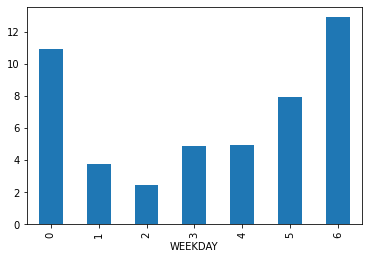

In [62]:
df_fd.groupby(by=["WEEKDAY"])["ARR_DELAY"].mean().plot(kind = "bar");

We have more delays on Sundays and Mondays

__7. Consider the weekend days only, compute, for each carrier, the mean arrival delay.__  
  Then consider the working days and compute, for each carrier, the mean arrival time.

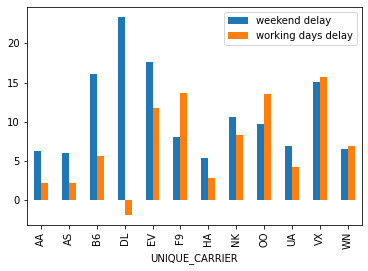

In [67]:
mask = df_fd.WEEKDAY.isin([5,6])
w_e = df_fd[mask].groupby(by=["UNIQUE_CARRIER"])["ARR_DELAY"].mean()
w_days = df_fd[~mask].groupby(by=["UNIQUE_CARRIER"])["ARR_DELAY"].mean()
w_e.name = "weekend delay"
w_days.name = "working days delay"
pd.concat([w_e, w_days], axis = 1).plot.bar();

• Are you able to identify companies that are delayed only in weekends or only in working days?
Why?

DL is delayed mostly on Weekends. Instead, F9 is delays mostly on Weekdays.

__8. Create a Pandas DataFrame with a multi-index composed of the columns: unique_carrier, origin, dest, fl_date.__

In [30]:
df_fd.columns

Index(['FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'ARR_DELAY', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 32', 'WEEKDAY', 'DELAYDELTA'],
      dtype='object')

In [31]:
df_multi = df_fd.set_index(['UNIQUE_CARRIER','ORIGIN','DEST','FL_DATE']).sort_index()

9. For each flight operated by American Airlines (AA) and Delta Airlines (DL), taken off from the Los
Angeles International Airport (LAX) and for each date, display the departure time and delay

In [32]:
df_multi.loc[(["AA", "DL"],"LAX"),["DEP_TIME","DEP_DELAY"]]

DEP_TIME  DEP_DELAY
UNIQUE_CARRIER ORIGIN DEST FL_DATE                        
AA             LAX    ATL  2017-01-01    1051.0       16.0
                           2017-01-01    1747.0      137.0
                           2017-01-02    1548.0       18.0
                           2017-01-02    2230.0       40.0
                           2017-01-02    1055.0       20.0
...                                         ...        ...
DL             LAX    TPA  2017-01-26    1146.0        1.0
                           2017-01-27    1137.0       -3.0
                           2017-01-29    1149.0        4.0
                           2017-01-30    1142.0       -3.0
                           2017-01-31    1206.0       21.0

[5437 rows x 2 columns]

10. For each flight that flew in the first week of the month, with LAX as destination airport, compute the mean arrival delay.

In [33]:
fil_df = df_multi.loc[pd.IndexSlice[:,:,"LAX","2017-01-01":"2017-01-07"],:]
fil_df.groupby("FL_NUM")["ARR_DELAY"].mean()

FL_NUM
1       -3.000000
2       66.428571
4       13.857143
5        2.714286
7       20.857143
          ...    
6344    47.000000
6354    60.000000
6522    49.666667
6563    -8.000000
6710    10.000000
Name: ARR_DELAY, Length: 986, dtype: float64

__11. Generate a pivot table containing the number of departed flights for each carrier and for each day
of the week and show it.__

In [34]:
pt = df_fd.pivot_table(columns= "WEEKDAY", index= "UNIQUE_CARRIER",values= "AIRLINE_ID", aggfunc= 'count')
pt

WEEKDAY,0,1,2,3,4,5,6
UNIQUE_CARRIER,,,,,,,
AA,12035,11457,9651,9854,9820,7905,11430
AS,2440,2261,1806,1935,1953,1762,2297
B6,4063,3942,3143,3258,3169,2643,3859
DL,12157,11512,9248,9695,9521,6492,10406
EV,5935,5649,4627,4923,4774,2905,5065
F9,1239,1214,976,983,986,955,1245
HA,987,966,791,802,864,826,1022
NK,1954,1970,1616,1610,1563,1470,1946
OO,8321,7912,6413,6631,6667,4913,7409


Compute now the pairwise correlation between the carriers and show it on a heatmap.

In [35]:
ptc = pt.T.corr()
ptc

UNIQUE_CARRIER,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
UNIQUE_CARRIER,,,,,,,,,,,,
AA,1.000000,0.945819,0.992210,0.969508,0.941361,0.905097,0.824336,0.945943,0.987100,0.978348,0.984490,0.974882
AS,0.945819,1.000000,0.962874,0.875104,0.812484,0.964065,0.929830,0.947410,0.914970,0.910091,0.898572,0.907263
B6,0.992210,0.962874,1.000000,0.950809,0.910819,0.940669,0.856940,0.975170,0.973749,0.958213,0.959973,0.977848
DL,0.969508,0.875104,0.950809,1.000000,0.991174,0.794245,0.684732,0.867335,0.994891,0.990281,0.986798,0.978026
EV,0.941361,0.812484,0.910819,0.991174,1.000000,0.718502,0.602185,0.808218,0.975723,0.978019,0.978730,0.948396
F9,0.905097,0.964065,0.940669,0.794245,0.718502,1.000000,0.963916,0.980321,0.847372,0.819232,0.821368,0.873601
HA,0.824336,0.929830,0.856940,0.684732,0.602185,0.963916,1.000000,0.902269,0.754106,0.736284,0.738432,0.762183
NK,0.945943,0.947410,0.975170,0.867335,0.808218,0.980321,0.902269,1.000000,0.904720,0.871417,0.877771,0.937891
OO,0.987100,0.914970,0.973749,0.994891,0.975723,0.847372,0.754106,0.904720,1.000000,0.992849,0.990796,0.985596


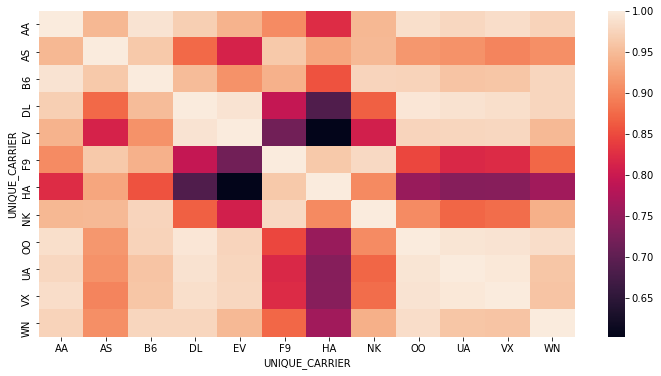

In [36]:
sns.heatmap(ptc);

__• What does this correlation matrix represent?__  
• Can you find any carrier with different flight plans?

It seems that Hawaiian Airlines (HA) has a different flight schedule compared to most of the other companies.  
Conversely, Delta Airlines and OO instead shares their plan with many companies.

12. Generate a pivot table containing the average arrival delay, for each carrier and for each day of the
week and show it.

In [37]:
pt = df_fd.pivot_table(index="WEEKDAY", columns= "UNIQUE_CARRIER", values= "ARR_DELAY", aggfunc= np.mean)
pt

UNIQUE_CARRIER,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
WEEKDAY,,,,,,,,,,,,
0,6.166653,1.744243,12.745117,5.652933,22.496612,23.677445,2.127660,15.736303,17.011347,9.877057,18.258567,10.891738
1,0.899956,-0.795982,7.053235,-4.535590,10.791889,13.563380,1.141969,7.421534,11.123554,5.498687,19.964444,2.835325
2,-0.733742,5.797327,1.656450,-5.432658,5.689274,8.149744,1.416984,2.780186,10.783691,1.972103,15.483039,3.760267
3,1.167107,4.365145,-0.285054,-4.369801,8.576665,11.303772,1.624220,7.838409,15.675984,1.998656,14.533079,8.793300
4,2.849597,1.041602,4.651251,-2.084867,9.070754,9.160569,8.109954,6.500963,12.453080,0.034880,9.178117,8.020024
5,4.184057,-0.996014,12.001899,23.544369,17.576776,3.518868,6.437046,6.157572,7.208863,0.276019,4.335271,3.303969
6,7.764121,11.400962,18.823760,23.250943,17.601550,11.655117,4.578999,14.073158,11.274667,10.890128,21.403409,8.716154


Compute now the pairwise correlation between the carriers and show it on a heatmap.

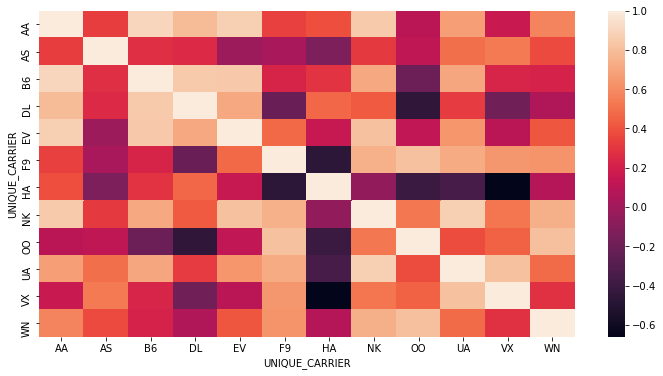

In [38]:
sns.heatmap(pt.corr());

-  What does this correlation matrix represent?
-  Can you find any carrier with different delay behaviors?

VX and HA have high negative Correlation.
AA has high correlation with B6 and EV.

13. Using a pivot table, for the carriers HA, DL, AA and AS compute the average deltadelay for each
day of the week. 

In [39]:
mask = df_fd.UNIQUE_CARRIER.isin(["HA", "DL", "AA", "AS"])
pt = df_fd[mask].pivot_table(index = "WEEKDAY", columns = "UNIQUE_CARRIER", values = "DELAYDELTA", aggfunc = np.mean)
pt

UNIQUE_CARRIER,AA,AS,DL,HA
WEEKDAY,,,,
0,-3.576209,-1.690789,-8.913563,0.258359
1,-4.621619,-1.625446,-10.211625,0.307772
2,-4.601184,-1.889198,-10.544913,0.759189
3,-4.091436,-2.130705,-10.604603,0.390762
4,-3.553686,-2.624551,-9.623199,0.746528
5,-4.558771,-3.453872,-5.979988,1.330508
6,-3.747053,0.542632,-7.001644,1.207066


Then, display the results on a line plot, having a line per carrier and the weekday
on the x-axis.

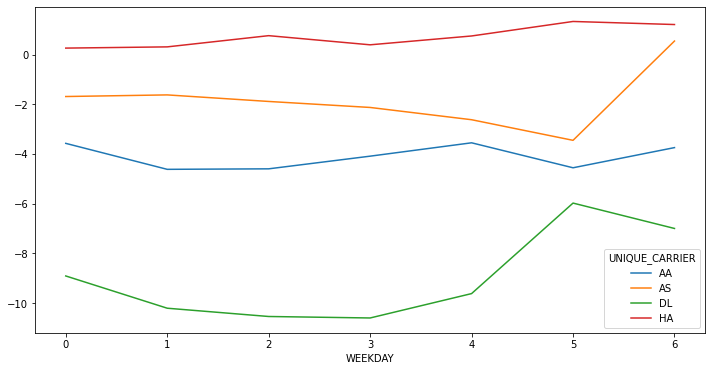

In [40]:
pt.plot.line();